In [1]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


%matplotlib inline

ModuleNotFoundError: No module named 'ANUBIS_triggered_functions'

In [ ]:
current_directory=  os.path.dirname(os.getcwd())

data = ANT.importDatafile(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_0227.h5")

In [ ]:
data_ATLAS = [sublist[:94230] for sublist in data]
etaHits, phiHits = ANT.divideHitCountsByRPC_Timed(data_ATLAS)

In [4]:
#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_ATLAS = ANT.FindCoincidentHits(etaHits,phiHits,15)

#Spatial Clustering
coincident_hits_ATLAS_clustered = ANT.cluster(coincident_hits_ATLAS)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

In [31]:
def check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
    #Used in filter_events() function to decide whether or not to save an event as described by the user's inputs.
    #The user selects an RPC to exclude from the filter. 
    #e.g. say we want to exclude RPC 4 and the user selects a min_RPC_number of 4. The check_event_...() will check if the
    #event has atleast 4 RPCs hit.

    #USING ONLY ETA FILTER HERE SINCE THIS IS WHAT TRIGGERS THE CHANNEL!

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]

    RPC_counter = 0
    chamber_counter = 0
    condition_1 = False
    condition_2 = False
    condition_3 = False

    for RPC in range(6):

        if RPC ==  RPC_excluded:
            pass
        else:
            if RPC<3:
                #Checking triplet layer.
                if event[2][RPC][1]:
                    #Reqiure atleast one eta strip to go off
                    RPC_counter+=1 
                    #If RPC has two eta and phi strips going off then consider it "hit"
                    if not condition_1:
                        #Count triplet chamber being hit.
                        chamber_counter+=1
                        condition_1 = True
            elif RPC == 3:
                #Singlet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_2:
                        chamber_counter+=1
                        condition_2 = True
            else:
                #Doublet layer
                if event[2][RPC][1]:
                    RPC_counter+=1
                    if not condition_3:
                        chamber_counter+=1
                        condition_3 = True
    return RPC_counter >= min_RPC_number and chamber_counter >= min_chamber_number

def filter_events_by_RPC(events,min_chamber_number,min_RPC_number,RPC_excluded):
    #Initiliase array of filtered events
    filtered_events = []

    for event in events:
        if check_event_attributes_by_RPC(event,min_chamber_number,min_RPC_number,RPC_excluded):
            filtered_events.append(event)

   # print(f"Number of events in filter = {len(filtered_events)}")
    
    return filtered_events

def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 15

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.


    #Extract x and y coords of cluster in event
    coords = ANT.extract_coords_timed_Chi2(event,max_cluster_size)

     # Filter out coords of RPC under test 

    test_coords = coords[RPC_excluded]
    coords[RPC_excluded] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo_Chi2(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = np.inf

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= ANT.fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?

    if dT != np.inf:

        if dT > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
    
def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

   # print(test_coords)

    if test_coords != [[],[],"N"]: 

        t = test_coords[:-1]# Doing this because .pop() seems to act globally...

        for x_v in t[0]:
            for y_v in t[1]:

                x = x_v[0]
                y = y_v[0]
    
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

def does_muon_hit_RPC(optimised_centroid, optimised_d, RPC):

    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] 
    #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    # x_bar = x_centroid + d_vector * t
    # Find value of paramter t when the muon trajectory passes through the RPC height.
    
    z_0 = optimised_centroid[2]
    z = RPC_heights[RPC]

    # t = (z-z_0)/d_z

    t = (z-z_0)/optimised_d[2]

    # Find expected (x,y) coordinates at that height.

    x = optimised_centroid[0] + t*optimised_d[0]
    y = optimised_centroid[1] + t*optimised_d[1]

    # Check if these (x,y) coordinates lie within the RPC. 

    #Extract x and y coords of cluster in event
    distance_per_phi_channel = 2.7625 #cm
    distance_per_eta_channel = 2.9844 #cm

    # Max y (eta side) is 31.5 * distance_per_eta_channel
    # Max x (phi side) is 63.5 * distance_per_phi_channel

    if 0 < x < 63.5*distance_per_phi_channel and 0 < y < 31.5*distance_per_eta_channel:
        #Return coordinates where you expect the muon to hit this RPC from the reconstructed event.
        return [x,y]
    else:
        #print("Muon does not hit RPC")
        return None   

def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[7],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)

    return successful_reconstructions/possible_reconstructions

INCLUDING CORRUPTED TIMESTAMPS ! 

0.0
880
0
0.40816326530612246
880
159
0.8163265306122449
880
322
1.2244897959183674
880
448
1.6326530612244898
880
545
2.0408163265306123
880
605
2.4489795918367347
880
624
2.857142857142857
880
632
3.2653061224489797
880
635
3.673469387755102
880
635
4.081632653061225
880
635
4.4897959183673475
880
635
4.8979591836734695
880
635
5.3061224489795915
880
635
5.714285714285714
880
635
6.122448979591837
880
635
6.530612244897959
880
635
6.938775510204081
880
635
7.346938775510204
880
635
7.755102040816327
880
635
8.16326530612245
880
635
8.571428571428571
880
635
8.979591836734695
880
635
9.387755102040817
880
635
9.795918367346939
880
635
10.204081632653061
880
635
10.612244897959183
880
635
11.020408163265307
880
635
11.428571428571429
880
635
11.83673469387755
880
635
12.244897959183675
880
635
12.653061224489797
880
635
13.061224489795919
880
635
13.46938775510204
880
635
13.877551020408163
880
635
14.285714285714286
880
635
14.693877551020408
880
635
15.10204081632653
880
635
15.51020

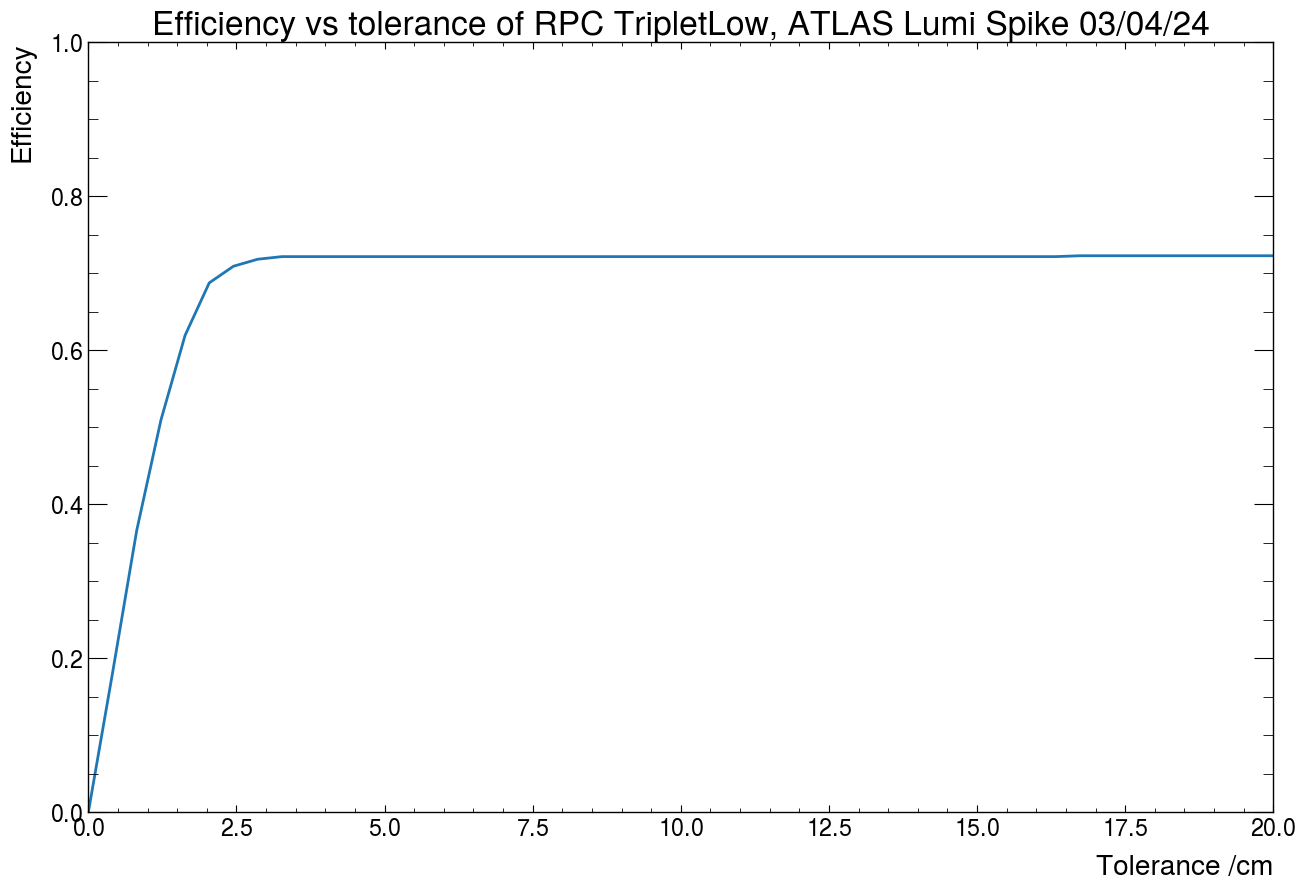

0.0
791
0
0.40816326530612246
791
110
0.8163265306122449
791
248
1.2244897959183674
791
380
1.6326530612244898
791
494
2.0408163265306123
791
562
2.4489795918367347
791
613
2.857142857142857
791
636
3.2653061224489797
791
646
3.673469387755102
791
655
4.081632653061225
791
655
4.4897959183673475
791
655
4.8979591836734695
791
655
5.3061224489795915
791
655
5.714285714285714
791
655
6.122448979591837
791
655
6.530612244897959
791
655
6.938775510204081
791
655
7.346938775510204
791
655
7.755102040816327
791
655
8.16326530612245
791
655
8.571428571428571
791
655
8.979591836734695
791
655
9.387755102040817
791
655
9.795918367346939
791
655
10.204081632653061
791
655
10.612244897959183
791
655
11.020408163265307
791
655
11.428571428571429
791
655
11.83673469387755
791
655
12.244897959183675
791
655
12.653061224489797
791
655
13.061224489795919
791
655
13.46938775510204
791
655
13.877551020408163
791
655
14.285714285714286
791
655
14.693877551020408
791
655
15.10204081632653
791
655
15.51020

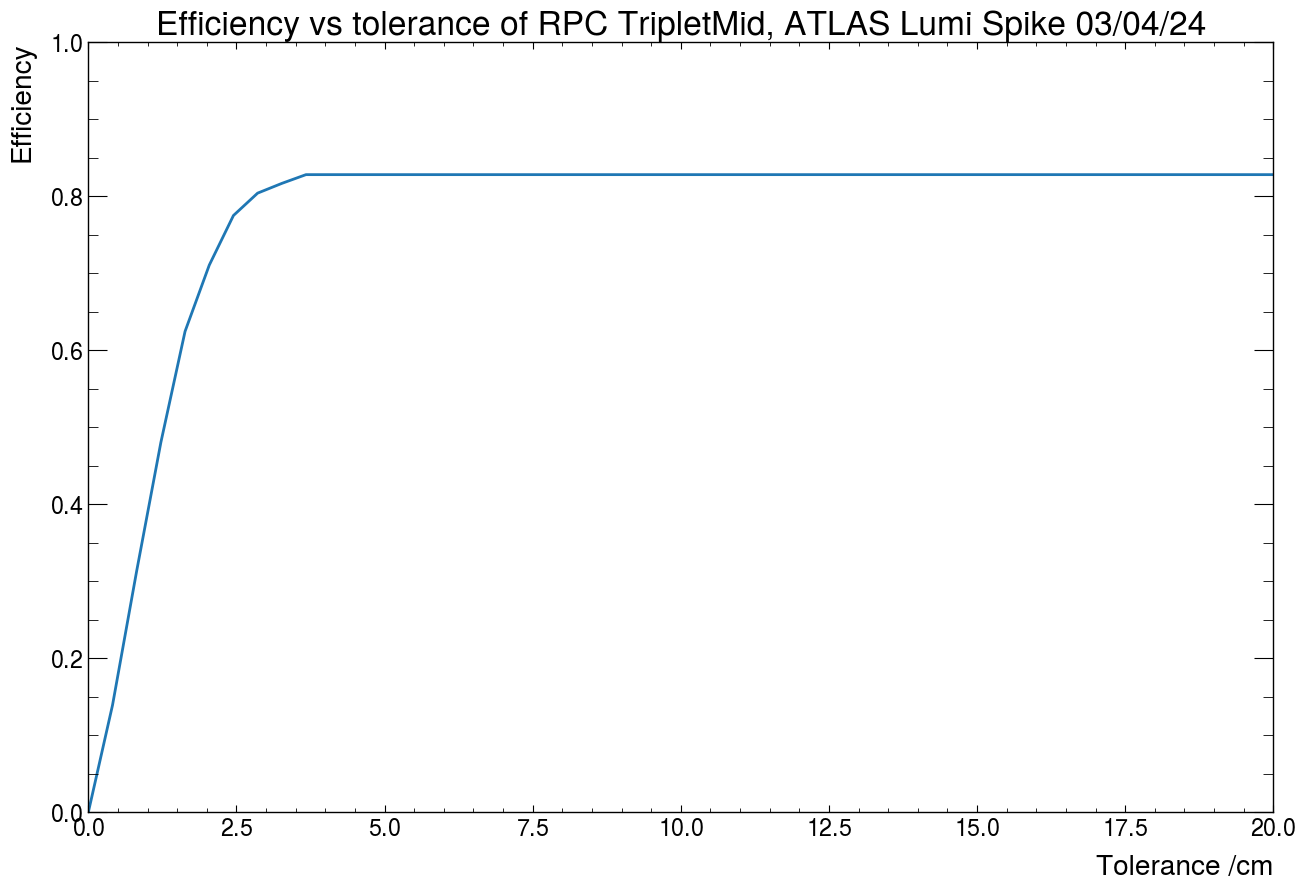

0.0
909
0
0.40816326530612246
909
68
0.8163265306122449
909
286
1.2244897959183674
909
463
1.6326530612244898
909
542
2.0408163265306123
909
593
2.4489795918367347
909
624
2.857142857142857
909
630
3.2653061224489797
909
636
3.673469387755102
909
636
4.081632653061225
909
640
4.4897959183673475
909
640
4.8979591836734695
909
640
5.3061224489795915
909
641
5.714285714285714
909
641
6.122448979591837
909
641
6.530612244897959
909
641
6.938775510204081
909
641
7.346938775510204
909
641
7.755102040816327
909
641
8.16326530612245
909
641
8.571428571428571
909
641
8.979591836734695
909
641
9.387755102040817
909
641
9.795918367346939
909
641
10.204081632653061
909
641
10.612244897959183
909
641
11.020408163265307
909
641
11.428571428571429
909
641
11.83673469387755
909
641
12.244897959183675
909
641
12.653061224489797
909
642
13.061224489795919
909
642
13.46938775510204
909
642
13.877551020408163
909
642
14.285714285714286
909
642
14.693877551020408
909
642
15.10204081632653
909
642
15.510204

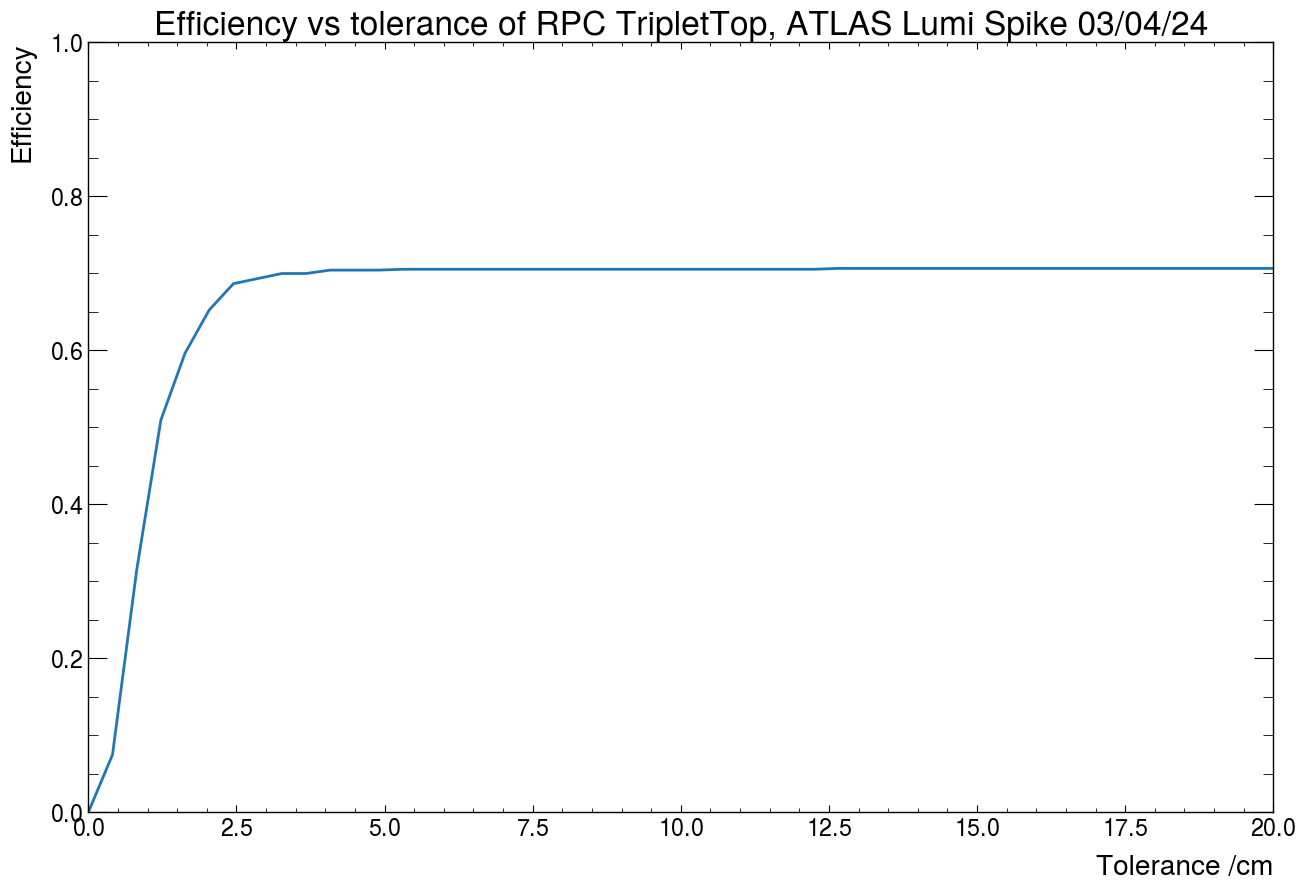

0.0


c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1230: RuntimeWarning: divide by zero encountered in scalar divide
  
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1235: RuntimeWarning: invalid value encountered in scalar multiply
  x_traj = centroid[0] + t*d[0]
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1230: RuntimeWarning: invalid value encountered in scalar divide
  
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1234: RuntimeWarning: invalid value encountered in scalar multiply
  


1042
0
0.40816326530612246
1042
30
0.8163265306122449
1042
67
1.2244897959183674
1042
134
1.6326530612244898
1042
250
2.0408163265306123
1042
356
2.4489795918367347
1042
459
2.857142857142857
1042
540
3.2653061224489797
1042
607
3.673469387755102
1042
641
4.081632653061225
1042
666
4.4897959183673475
1042
684
4.8979591836734695
1042
703
5.3061224489795915
1042
711
5.714285714285714
1042
718
6.122448979591837
1042
724
6.530612244897959
1042
726
6.938775510204081
1042
726
7.346938775510204
1042
728
7.755102040816327
1042
730
8.16326530612245
1042
731
8.571428571428571
1042
733
8.979591836734695
1042
733
9.387755102040817
1042
734
9.795918367346939
1042
738
10.204081632653061
1042
743
10.612244897959183
1042
744
11.020408163265307
1042
745
11.428571428571429
1042
745
11.83673469387755
1042
745
12.244897959183675
1042
746
12.653061224489797
1042
748
13.061224489795919
1042
749
13.46938775510204
1042
751
13.877551020408163
1042
752
14.285714285714286
1042
752
14.693877551020408
1042
752
15.

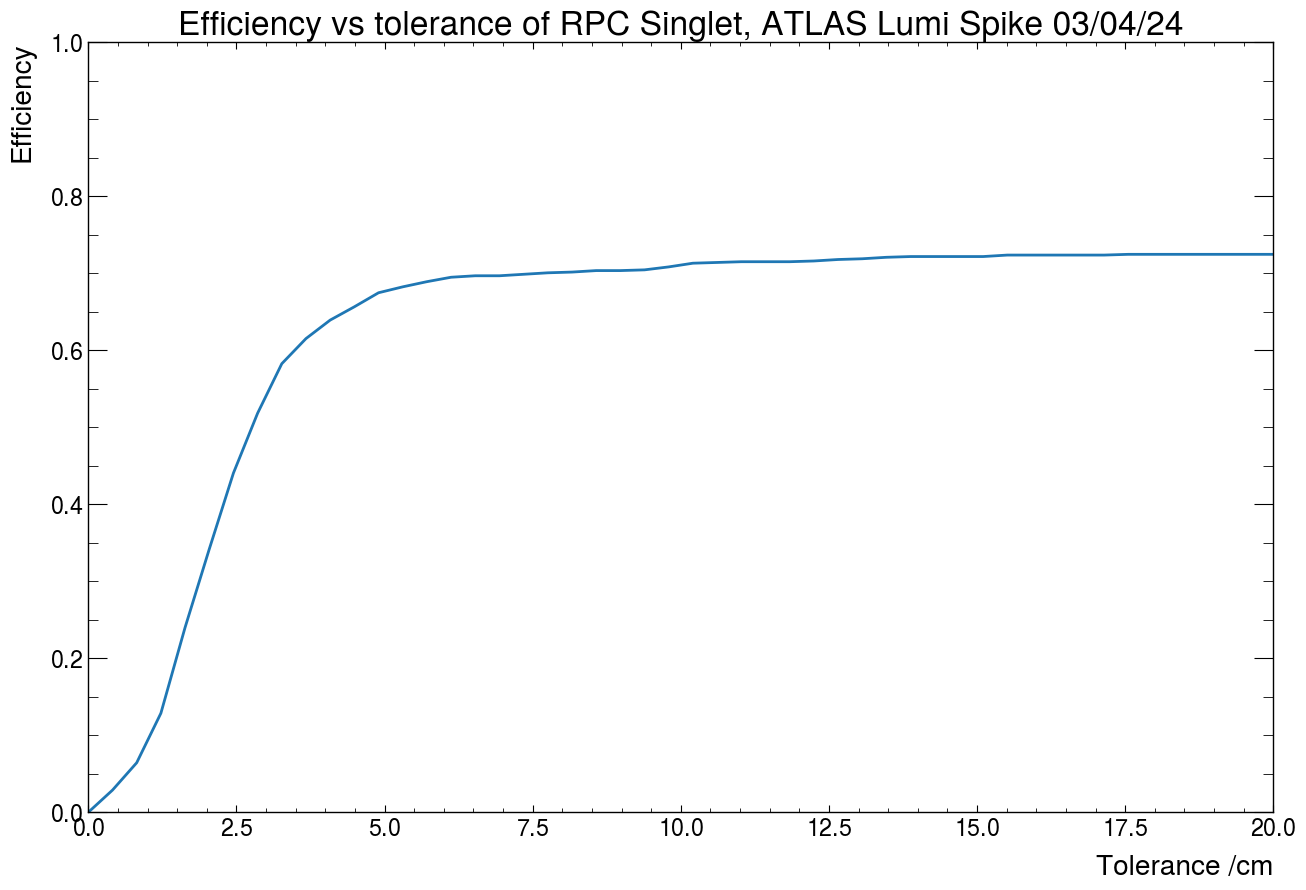

0.0
1499
0
0.40816326530612246
1499
76
0.8163265306122449
1499
190
1.2244897959183674
1499
247
1.6326530612244898
1499
359
2.0408163265306123
1499
453
2.4489795918367347
1499
521
2.857142857142857
1499
557
3.2653061224489797
1499
589
3.673469387755102
1499
610
4.081632653061225
1499
618
4.4897959183673475
1499
622
4.8979591836734695
1499
622
5.3061224489795915
1499
622
5.714285714285714
1499
622
6.122448979591837
1499
622
6.530612244897959
1499
624
6.938775510204081
1499
625
7.346938775510204
1499
626
7.755102040816327
1499
627
8.16326530612245
1499
627
8.571428571428571
1499
629
8.979591836734695
1499
630
9.387755102040817
1499
633
9.795918367346939
1499
634
10.204081632653061
1499
634
10.612244897959183
1499
634
11.020408163265307
1499
634
11.428571428571429
1499
634
11.83673469387755
1499
634
12.244897959183675
1499
634
12.653061224489797
1499
634
13.061224489795919
1499
634
13.46938775510204
1499
634
13.877551020408163
1499
634
14.285714285714286
1499
634
14.693877551020408
1499
63

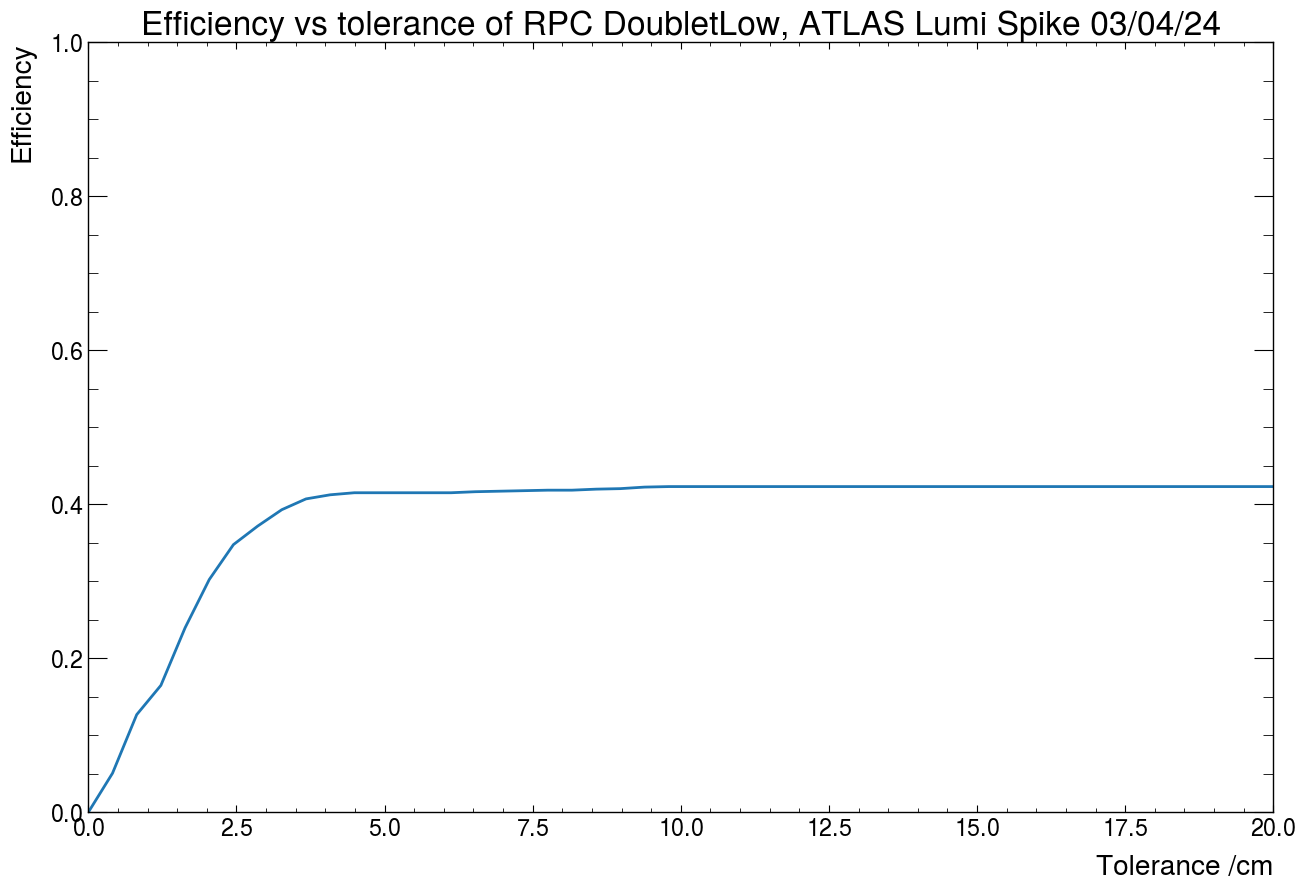

0.0
1555
0
0.40816326530612246
1555
40
0.8163265306122449
1555
159
1.2244897959183674
1555
327
1.6326530612244898
1555
429
2.0408163265306123
1555
500
2.4489795918367347
1555
558
2.857142857142857
1555
582
3.2653061224489797
1555
594
3.673469387755102
1555
597
4.081632653061225
1555
598
4.4897959183673475
1555
600
4.8979591836734695
1555
601
5.3061224489795915
1555
601
5.714285714285714
1555
601
6.122448979591837
1555
604
6.530612244897959
1555
605
6.938775510204081
1555
607
7.346938775510204
1555
607
7.755102040816327
1555
609
8.16326530612245
1555
609
8.571428571428571
1555
610
8.979591836734695
1555
612
9.387755102040817
1555
613
9.795918367346939
1555
614
10.204081632653061
1555
614
10.612244897959183
1555
616
11.020408163265307
1555
616
11.428571428571429
1555
616
11.83673469387755
1555
617
12.244897959183675
1555
617
12.653061224489797
1555
618
13.061224489795919
1555
619
13.46938775510204
1555
620
13.877551020408163
1555
621
14.285714285714286
1555
621
14.693877551020408
1555
62

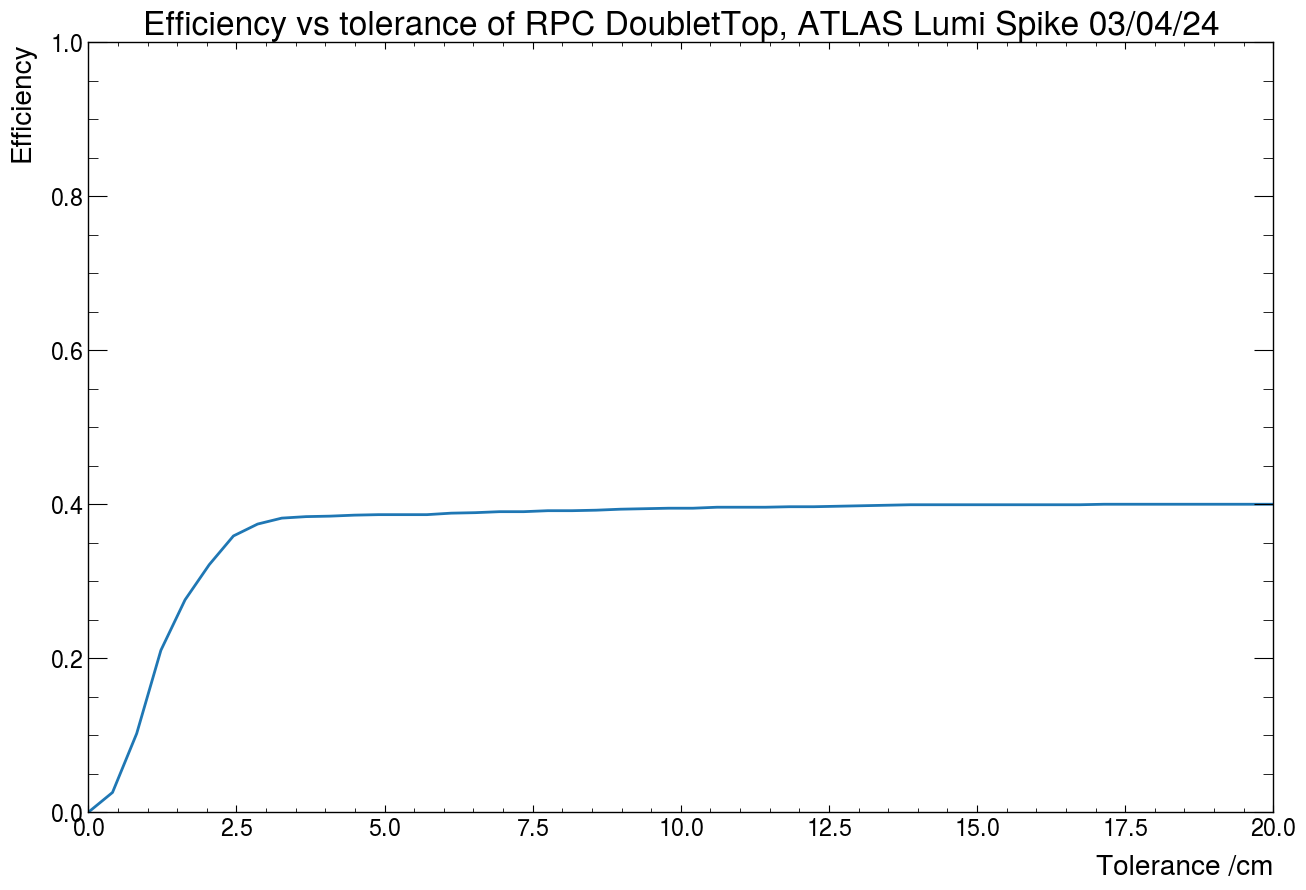

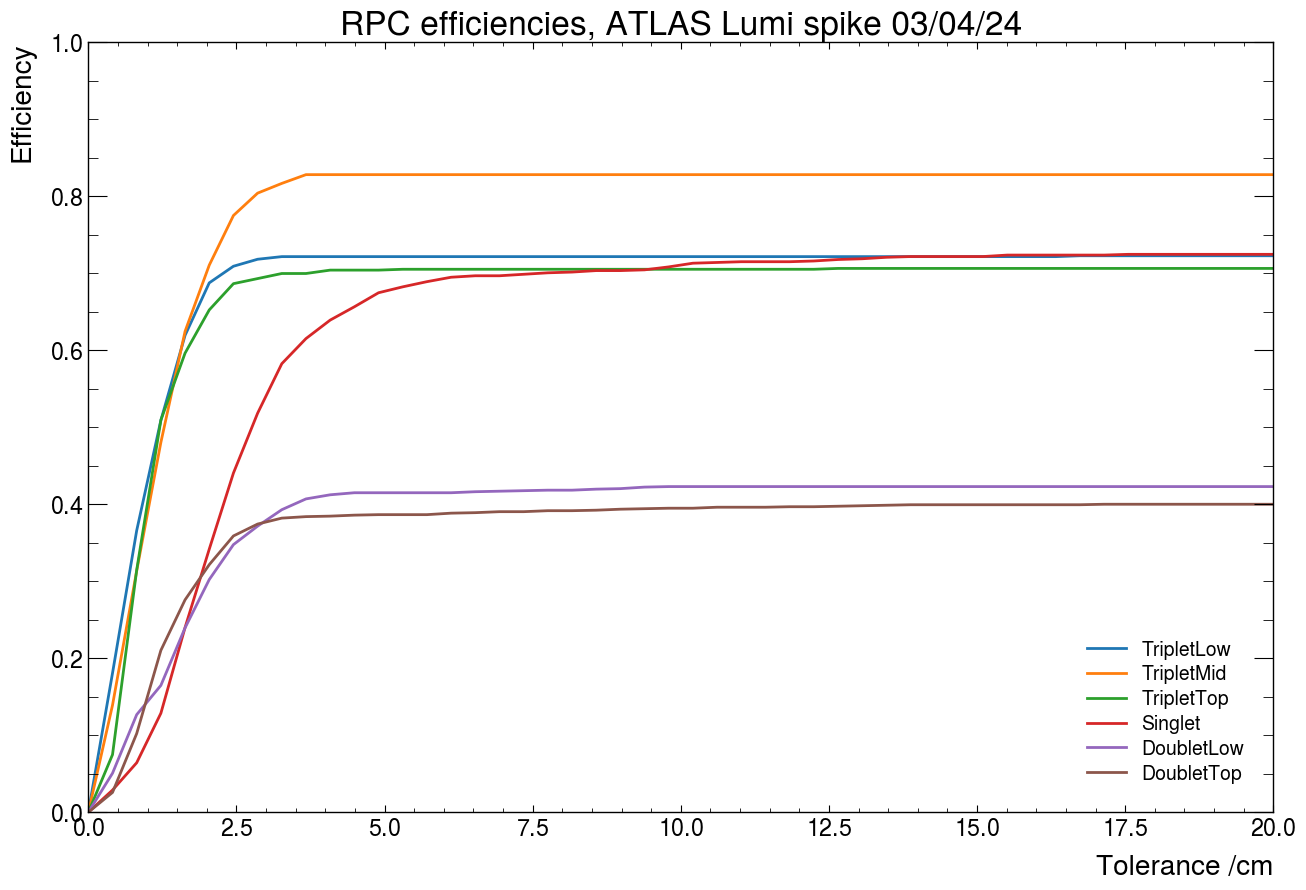

In [40]:
tolerances = np.linspace(0,20,50)

RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']
efficiencies= []

for RPC in range(6):

    efficiencies_RPC = []

    for tol in tolerances:
        print(tol)
        efficiencies_RPC.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,RPC,tol))

    efficiencies.append(efficiencies_RPC)

    # Zip the nested lists together
    toWrite = zip(efficiencies_RPC, tolerances)

    with open(f'{RPCS[RPC]}.csv', 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(toWrite)

    plt.figure(figsize=(15,10))

    plt.plot(tolerances, efficiencies_RPC)
    plt.xlabel('Tolerance /cm')
    plt.ylabel('Efficiency')
    plt.ylim(0,1)

    plt.title(f'Efficiency vs tolerance of RPC {RPCS[RPC]}, ATLAS Lumi Spike 03/04/24')

    plt.show()

plt.figure(figsize=(15,10))

for ind,data in enumerate(efficiencies):
    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

plt.title("RPC efficiencies, ATLAS Lumi spike 03/04/24")

plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.ylim(0,1)

plt.legend()
plt.show()


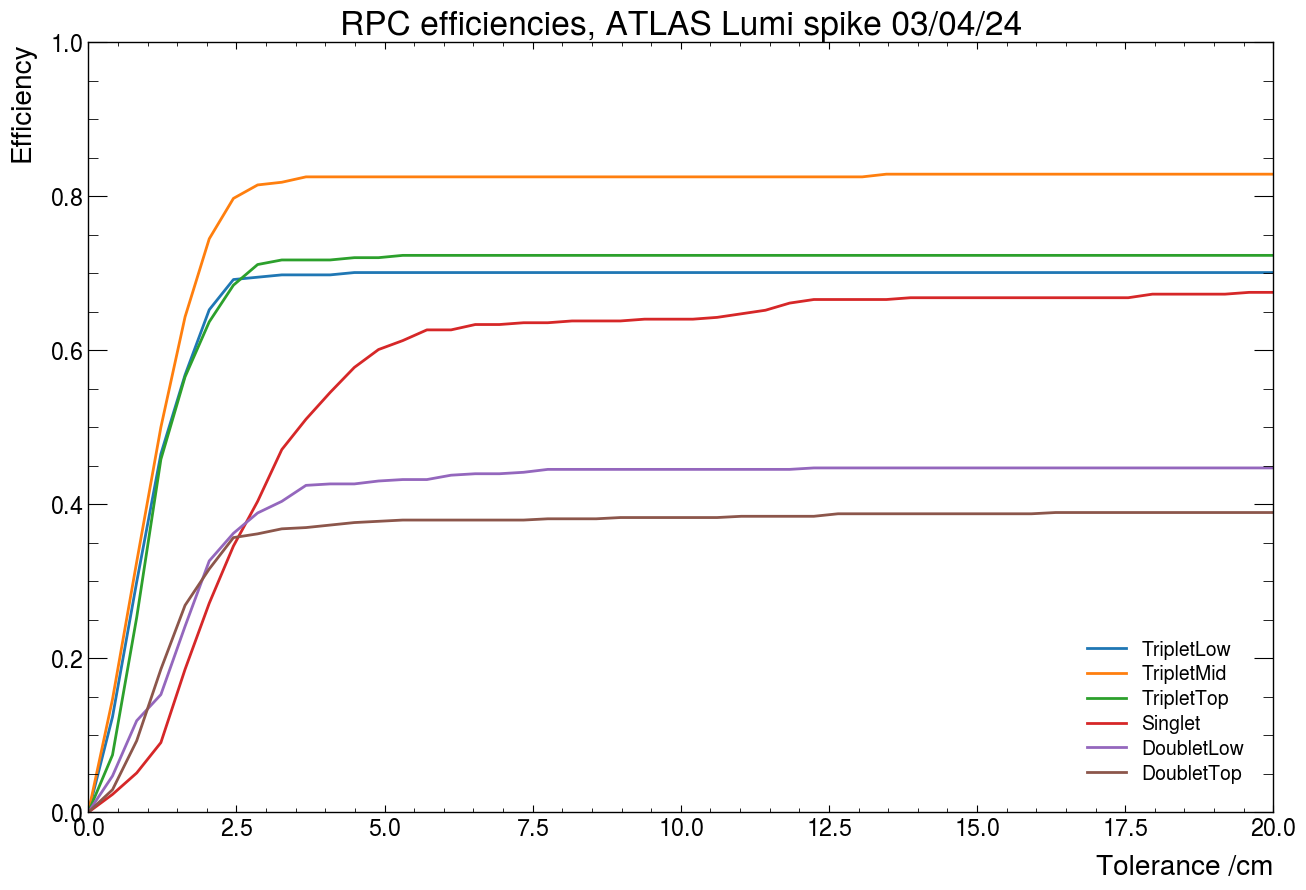

In [39]:
plt.figure(figsize=(15,10))

for ind,data in enumerate(efficiencies):
    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

plt.title("RPC efficiencies, ATLAS Lumi spike 03/04/24")

plt.ylim(0,1)

plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency'
)

plt.legend()
plt.show()

In [37]:
Cosmics = ANT.importFromHDF5File(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_1427_cosmics.h5")

data_cosmics = [sublist[:83169] for sublist in Cosmics]

c_etaHits, c_phiHits = ANT.divideHitCountsByRPC_Timed(data_cosmics)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_cosmics = ANT.FindCoincidentHits(c_etaHits,c_phiHits,15)

#Spatial Clustering
coincident_hits_cosmics_clustered = ANT.cluster(coincident_hits_cosmics)

print(len(coincident_hits_cosmics_clustered))

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

0.0
331
0
0.40816326530612246
331
41
0.8163265306122449
331
99
1.2244897959183674
331
154
1.6326530612244898
331
188
2.0408163265306123
331
216
2.4489795918367347
331
229
2.857142857142857
331
230
3.2653061224489797
331
231
3.673469387755102
331
231
4.081632653061225
331
231
4.4897959183673475
331
232
4.8979591836734695
331
232
5.3061224489795915
331
232
5.714285714285714
331
232
6.122448979591837
331
232
6.530612244897959
331
232
6.938775510204081
331
232
7.346938775510204
331
232
7.755102040816327
331
232
8.16326530612245
331
232
8.571428571428571
331
232
8.979591836734695
331
232
9.387755102040817
331
232
9.795918367346939
331
232
10.204081632653061
331
232
10.612244897959183
331
232
11.020408163265307
331
232
11.428571428571429
331
232
11.83673469387755
331
232
12.244897959183675
331
232
12.653061224489797
331
232
13.061224489795919
331
232
13.46938775510204
331
232
13.877551020408163
331
232
14.285714285714286
331
232
14.693877551020408
331
232
15.10204081632653
331
232
15.5102040

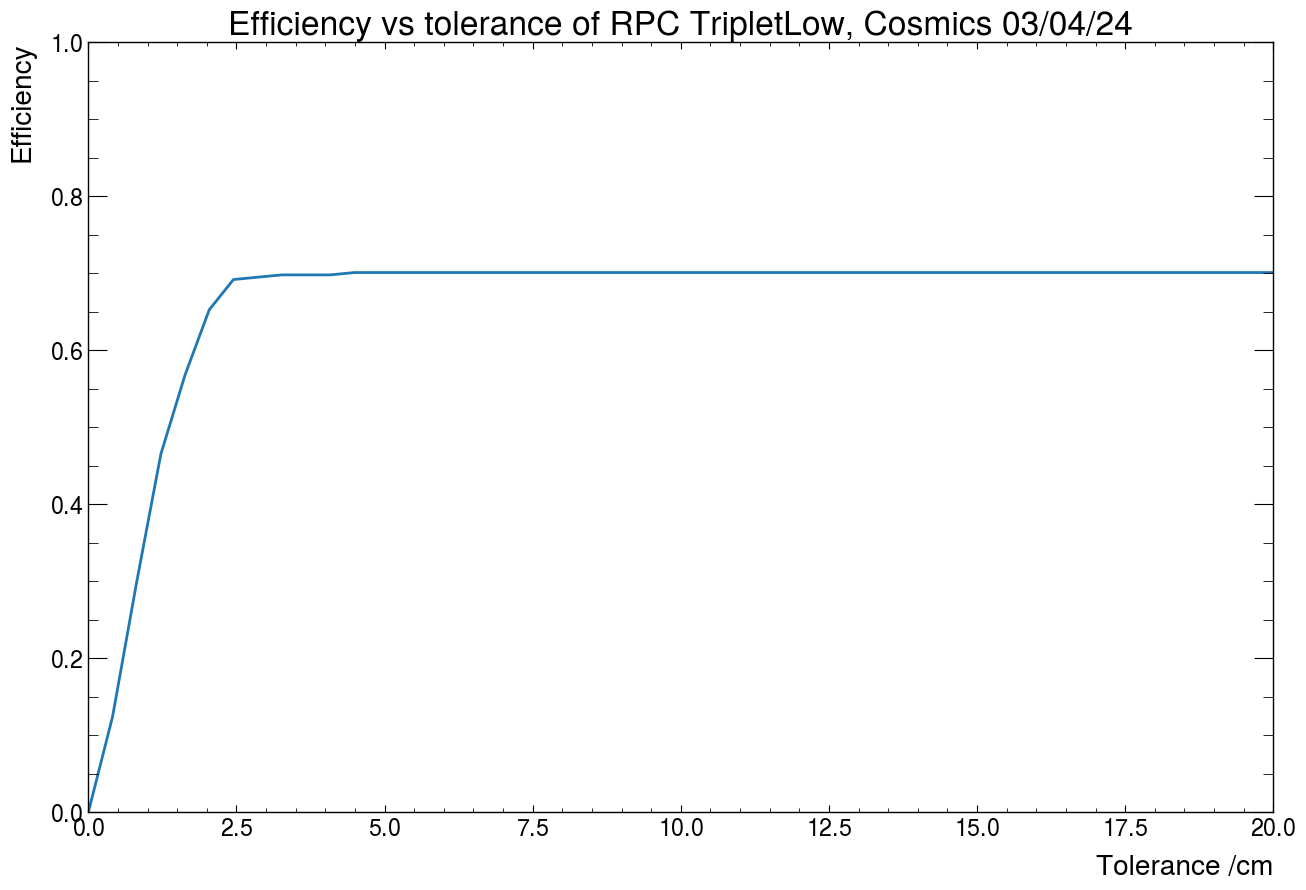

0.0
286
0
0.40816326530612246
286
42
0.8163265306122449
286
93
1.2244897959183674
286
143
1.6326530612244898
286
184
2.0408163265306123
286
213
2.4489795918367347
286
228
2.857142857142857
286
233
3.2653061224489797
286
234
3.673469387755102
286
236
4.081632653061225
286
236
4.4897959183673475
286
236
4.8979591836734695
286
236
5.3061224489795915
286
236
5.714285714285714
286
236
6.122448979591837
286
236
6.530612244897959
286
236
6.938775510204081
286
236
7.346938775510204
286
236
7.755102040816327
286
236
8.16326530612245
286
236
8.571428571428571
286
236
8.979591836734695
286
236
9.387755102040817
286
236
9.795918367346939
286
236
10.204081632653061
286
236
10.612244897959183
286
236
11.020408163265307
286
236
11.428571428571429
286
236
11.83673469387755
286
236
12.244897959183675
286
236
12.653061224489797
286
236
13.061224489795919
286
236
13.46938775510204
286
237
13.877551020408163
286
237
14.285714285714286
286
237
14.693877551020408
286
237
15.10204081632653
286
237
15.5102040

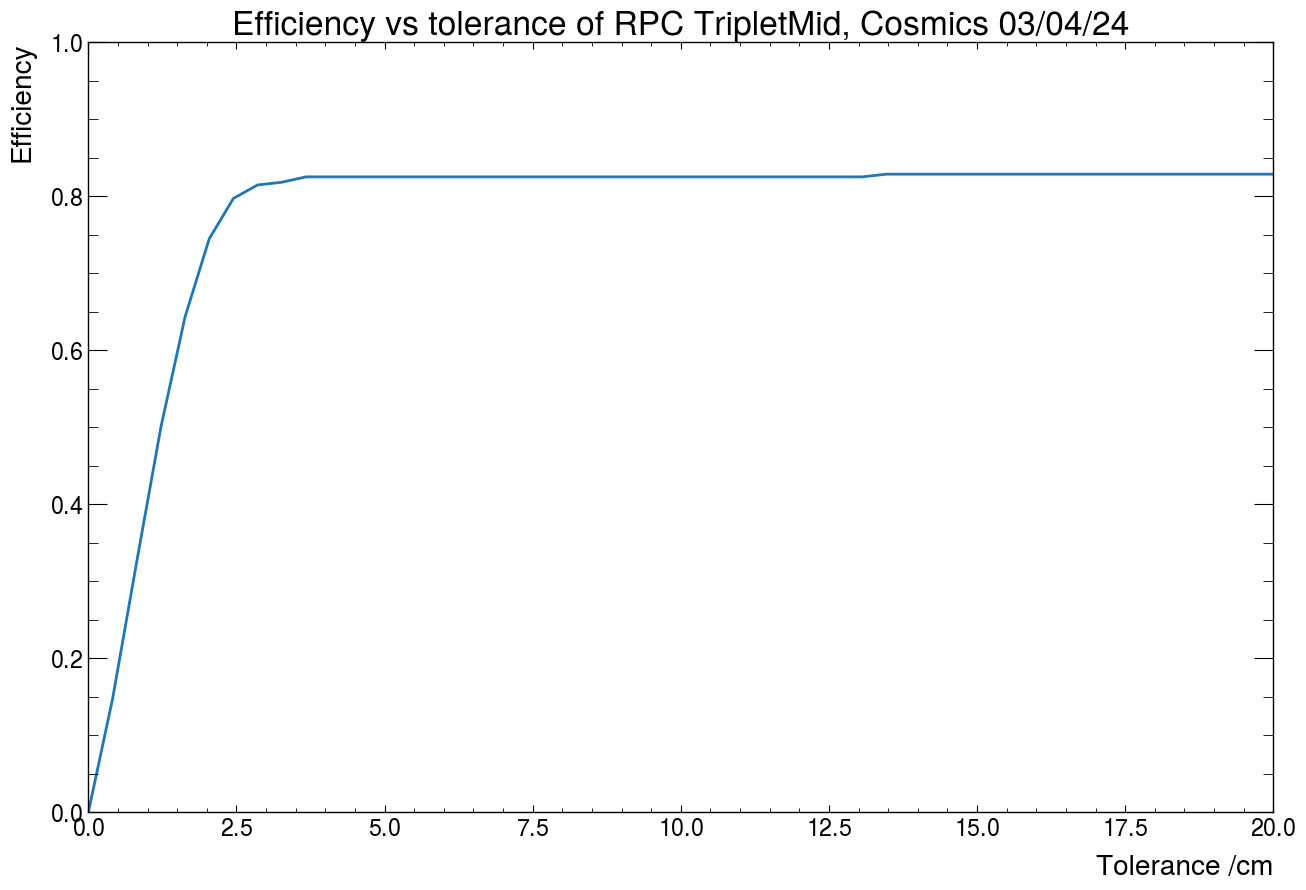

0.0
336
0
0.40816326530612246
336
25
0.8163265306122449
336
85
1.2244897959183674
336
154
1.6326530612244898
336
190
2.0408163265306123
336
214
2.4489795918367347
336
230
2.857142857142857
336
239
3.2653061224489797
336
241
3.673469387755102
336
241
4.081632653061225
336
241
4.4897959183673475
336
242
4.8979591836734695
336
242
5.3061224489795915
336
243
5.714285714285714
336
243
6.122448979591837
336
243
6.530612244897959
336
243
6.938775510204081
336
243
7.346938775510204
336
243
7.755102040816327
336
243
8.16326530612245
336
243
8.571428571428571
336
243
8.979591836734695
336
243
9.387755102040817
336
243
9.795918367346939
336
243
10.204081632653061
336
243
10.612244897959183
336
243
11.020408163265307
336
243
11.428571428571429
336
243
11.83673469387755
336
243
12.244897959183675
336
243
12.653061224489797
336
243
13.061224489795919
336
243
13.46938775510204
336
243
13.877551020408163
336
243
14.285714285714286
336
243
14.693877551020408
336
243
15.10204081632653
336
243
15.5102040

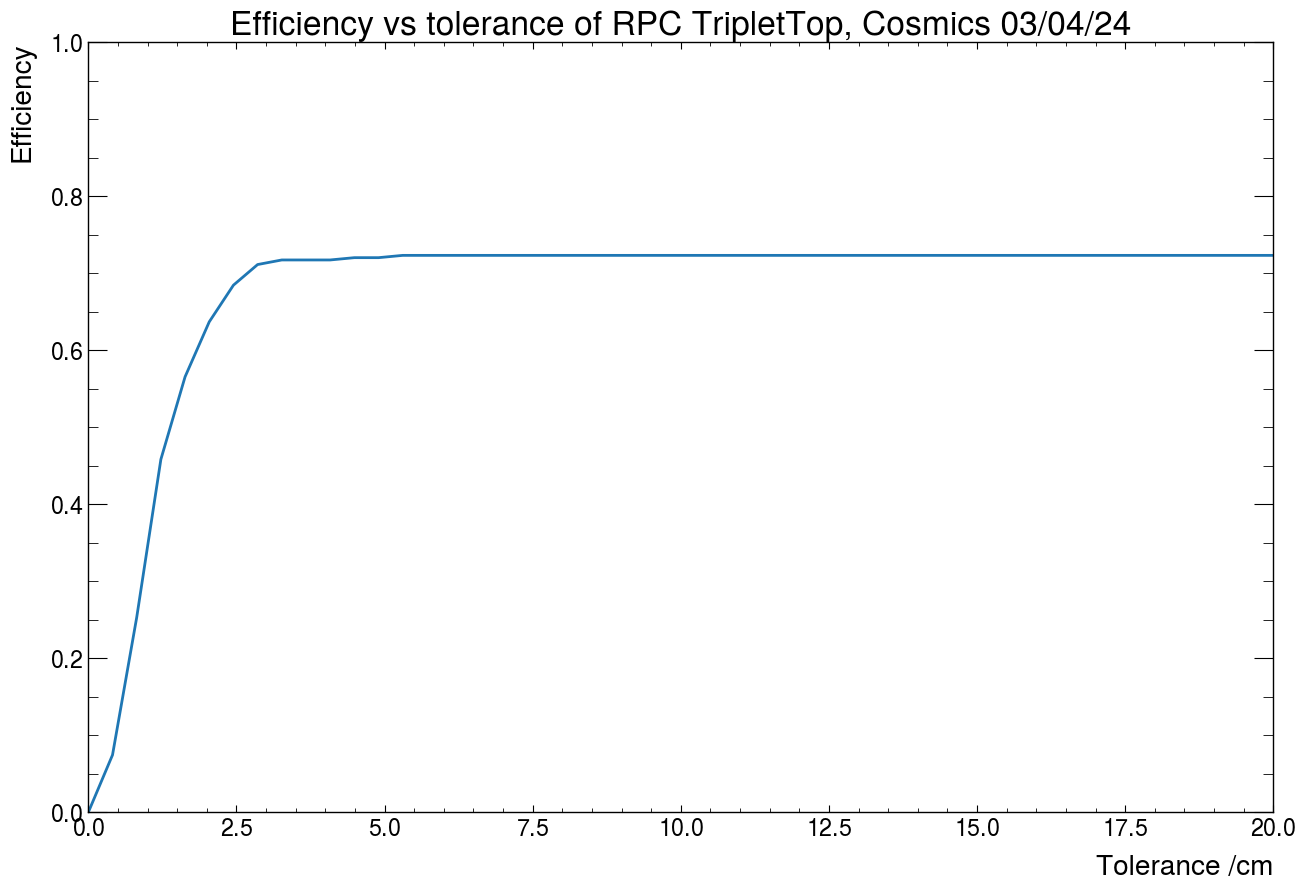

0.0


c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1230: RuntimeWarning: divide by zero encountered in scalar divide
  
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1235: RuntimeWarning: invalid value encountered in scalar multiply
  x_traj = centroid[0] + t*d[0]
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1230: RuntimeWarning: invalid value encountered in scalar divide
  
c:\Users\patri\Desktop\Part III project\ProANUBISdata_repository\ProAnubisReconstruction\ProAnubis_CERN\Scripts\ANUBIS_triggered_functions.py:1234: RuntimeWarning: invalid value encountered in scalar multiply
  


431
0
0.40816326530612246
431
10
0.8163265306122449
431
22
1.2244897959183674
431
39
1.6326530612244898
431
80
2.0408163265306123
431
117
2.4489795918367347
431
149
2.857142857142857
431
174
3.2653061224489797
431
203
3.673469387755102
431
220
4.081632653061225
431
235
4.4897959183673475
431
249
4.8979591836734695
431
259
5.3061224489795915
431
264
5.714285714285714
431
270
6.122448979591837
431
270
6.530612244897959
431
273
6.938775510204081
431
273
7.346938775510204
431
274
7.755102040816327
431
274
8.16326530612245
431
275
8.571428571428571
431
275
8.979591836734695
431
275
9.387755102040817
431
276
9.795918367346939
431
276
10.204081632653061
431
276
10.612244897959183
431
277
11.020408163265307
431
279
11.428571428571429
431
281
11.83673469387755
431
285
12.244897959183675
431
287
12.653061224489797
431
287
13.061224489795919
431
287
13.46938775510204
431
287
13.877551020408163
431
288
14.285714285714286
431
288
14.693877551020408
431
288
15.10204081632653
431
288
15.5102040816326

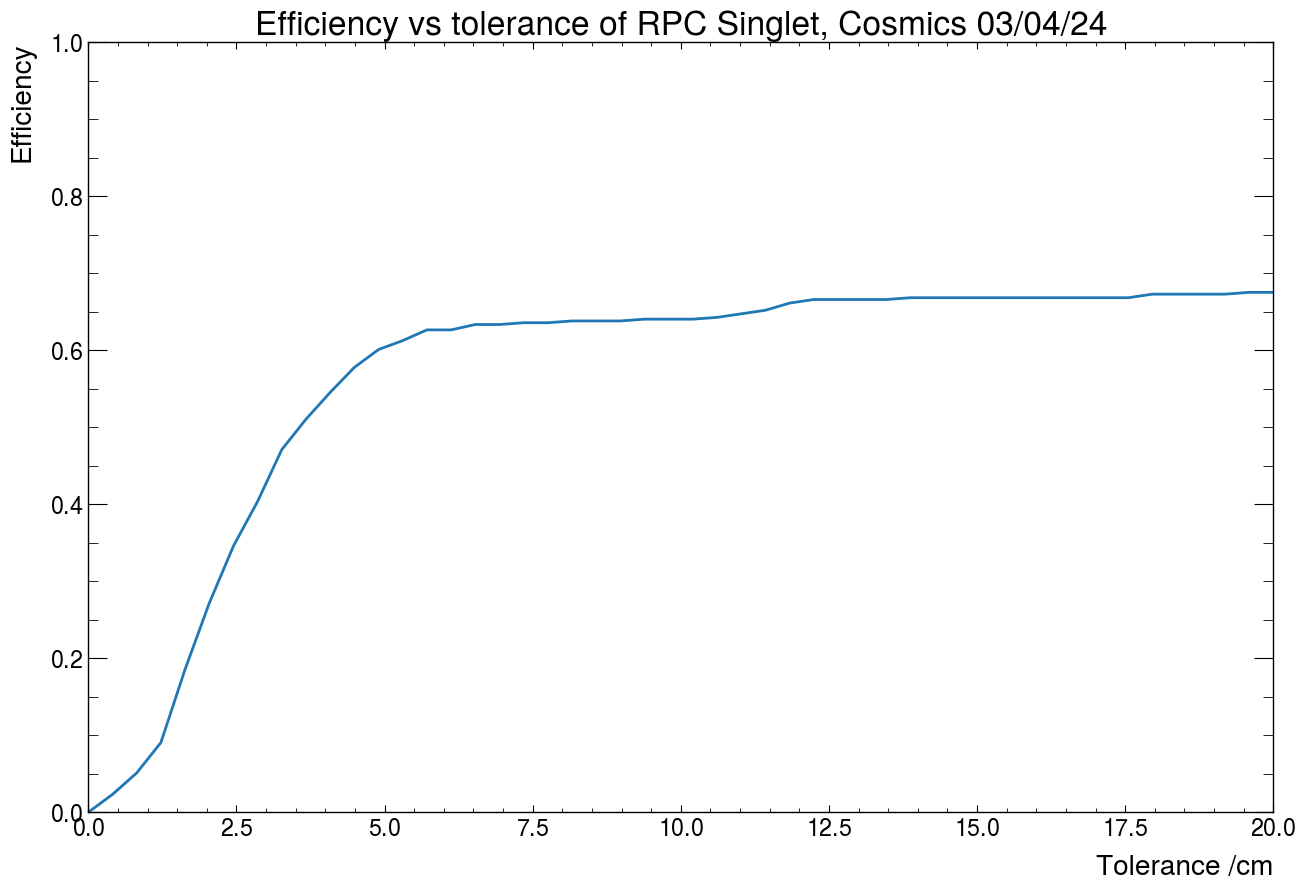

0.0
530
0
0.40816326530612246
530
25
0.8163265306122449
530
63
1.2244897959183674
530
81
1.6326530612244898
530
128
2.0408163265306123
530
173
2.4489795918367347
530
192
2.857142857142857
530
206
3.2653061224489797
530
214
3.673469387755102
530
225
4.081632653061225
530
226
4.4897959183673475
530
226
4.8979591836734695
530
228
5.3061224489795915
530
229
5.714285714285714
530
229
6.122448979591837
530
232
6.530612244897959
530
233
6.938775510204081
530
233
7.346938775510204
530
234
7.755102040816327
530
236
8.16326530612245
530
236
8.571428571428571
530
236
8.979591836734695
530
236
9.387755102040817
530
236
9.795918367346939
530
236
10.204081632653061
530
236
10.612244897959183
530
236
11.020408163265307
530
236
11.428571428571429
530
236
11.83673469387755
530
236
12.244897959183675
530
237
12.653061224489797
530
237
13.061224489795919
530
237
13.46938775510204
530
237
13.877551020408163
530
237
14.285714285714286
530
237
14.693877551020408
530
237
15.10204081632653
530
237
15.51020408

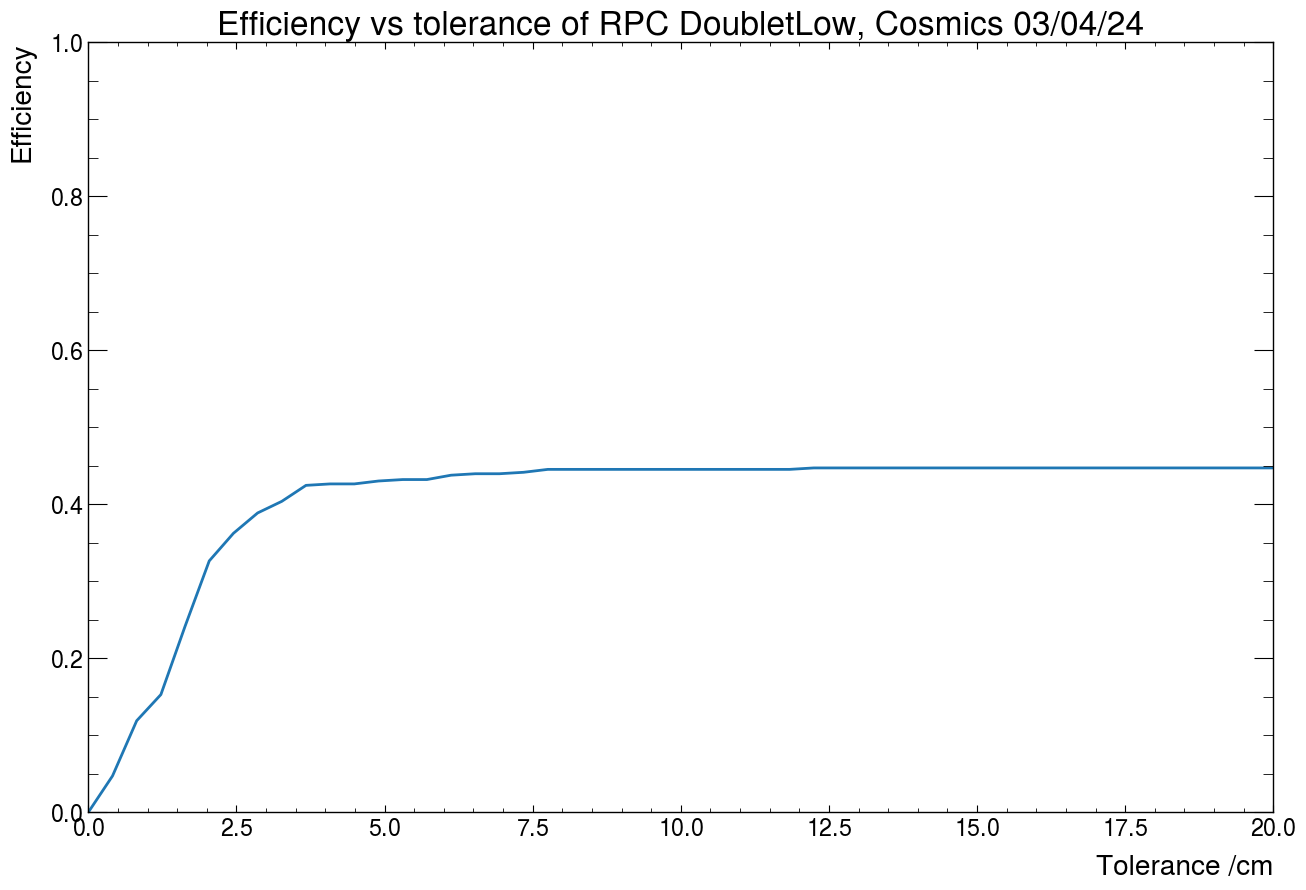

0.0
614
0
0.40816326530612246
614
18
0.8163265306122449
614
57
1.2244897959183674
614
114
1.6326530612244898
614
165
2.0408163265306123
614
194
2.4489795918367347
614
219
2.857142857142857
614
222
3.2653061224489797
614
226
3.673469387755102
614
227
4.081632653061225
614
229
4.4897959183673475
614
231
4.8979591836734695
614
232
5.3061224489795915
614
233
5.714285714285714
614
233
6.122448979591837
614
233
6.530612244897959
614
233
6.938775510204081
614
233
7.346938775510204
614
233
7.755102040816327
614
234
8.16326530612245
614
234
8.571428571428571
614
234
8.979591836734695
614
235
9.387755102040817
614
235
9.795918367346939
614
235
10.204081632653061
614
235
10.612244897959183
614
235
11.020408163265307
614
236
11.428571428571429
614
236
11.83673469387755
614
236
12.244897959183675
614
236
12.653061224489797
614
238
13.061224489795919
614
238
13.46938775510204
614
238
13.877551020408163
614
238
14.285714285714286
614
238
14.693877551020408
614
238
15.10204081632653
614
238
15.5102040

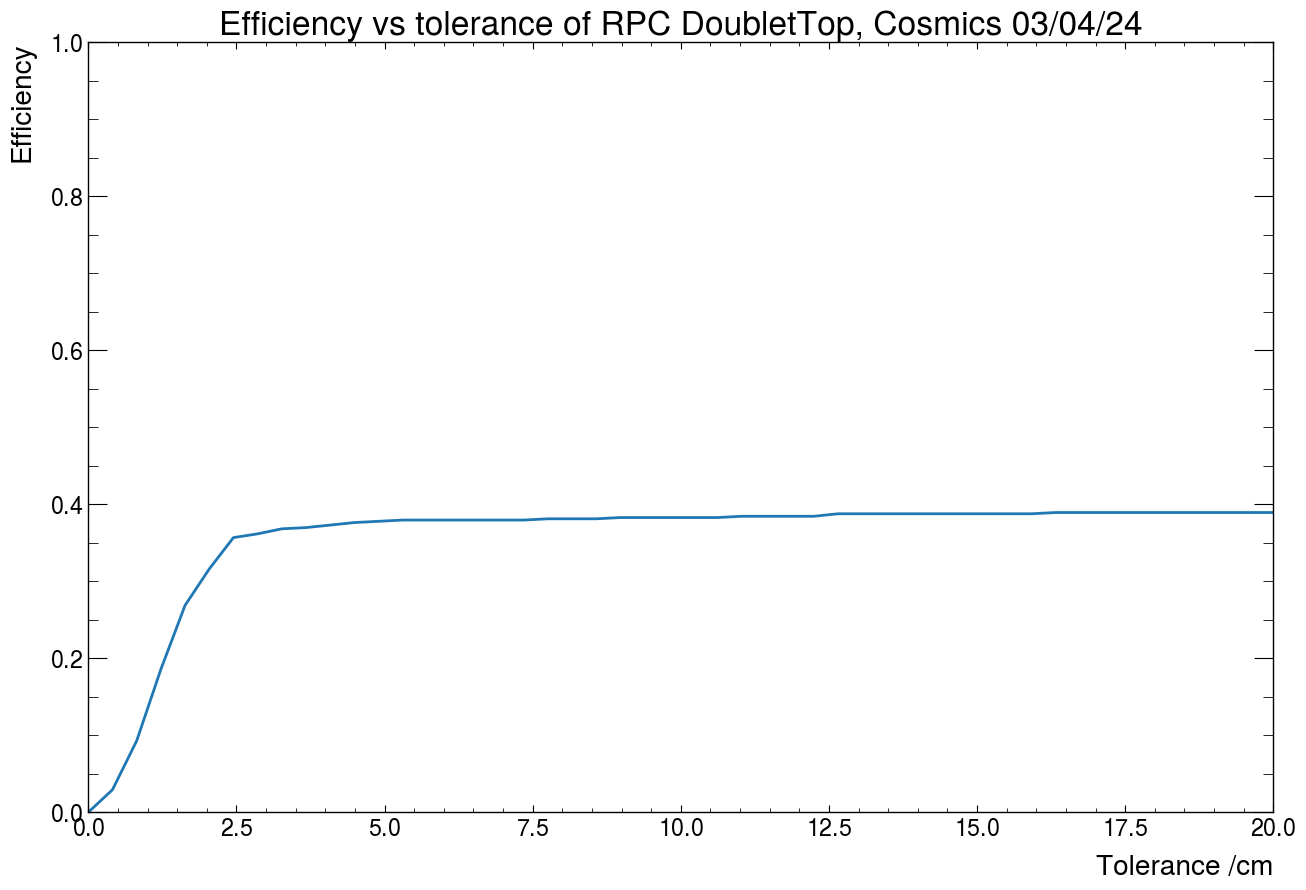

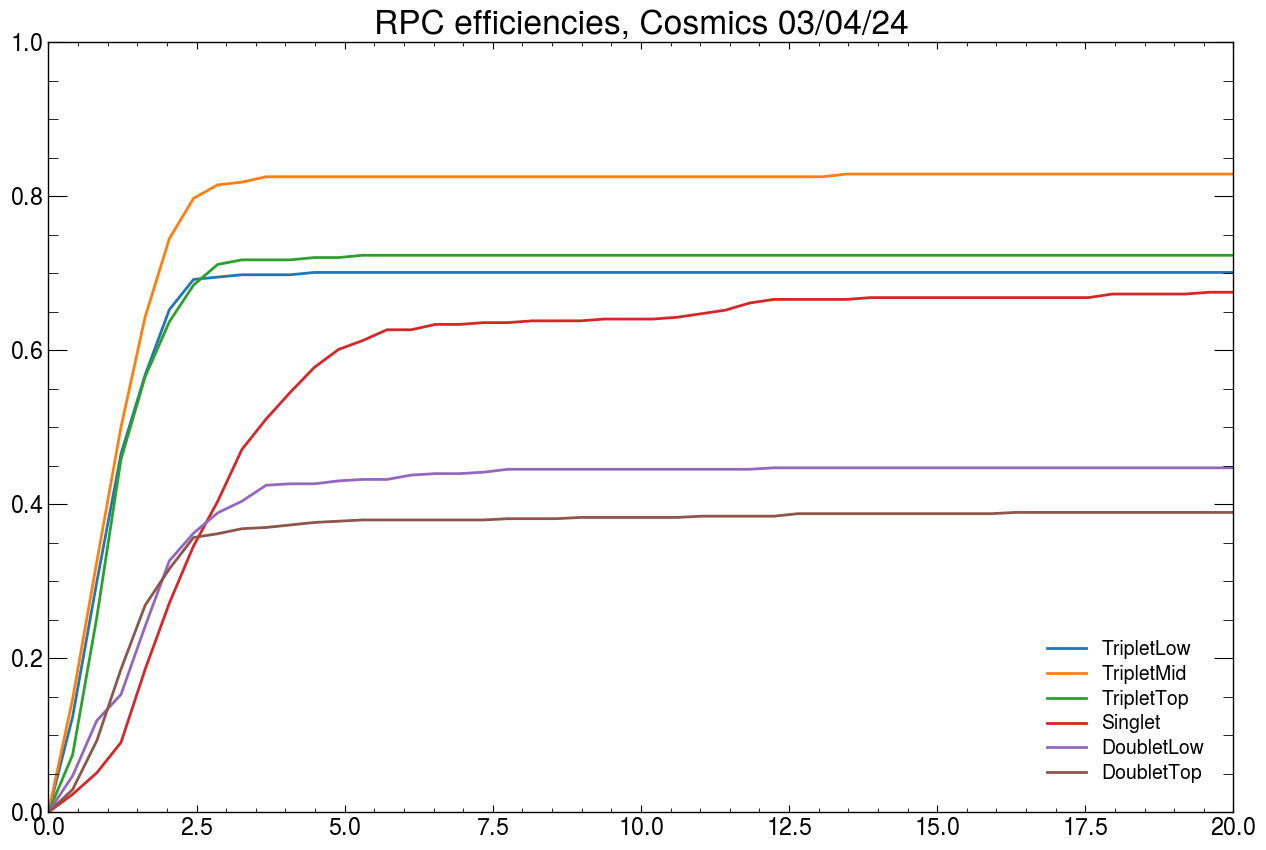

In [38]:
tolerances = np.linspace(0,20,50)

RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']
efficiencies= []

for RPC in range(6):

    efficiencies_RPC = []

    for tol in tolerances:
        print(tol)
        efficiencies_RPC.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,RPC,tol))

    efficiencies.append(efficiencies_RPC)

    # Zip the nested lists together
    toWrite = zip(efficiencies_RPC, tolerances)

    with open(f'{RPCS[RPC]}.csv', 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(toWrite)

    plt.figure(figsize=(15,10))

    plt.plot(tolerances, efficiencies_RPC)
    plt.xlabel('Tolerance /cm')
    plt.ylabel('Efficiency')
    plt.ylim(0,1)

    plt.title(f'Efficiency vs tolerance of RPC {RPCS[RPC]}, Cosmics 03/04/24')

    plt.show()

plt.figure(figsize=(15,10))

for ind,data in enumerate(efficiencies):
    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

plt.title("RPC efficiencies, Cosmics 03/04/24")

plt.ylim(0,1)

plt.legend()
plt.show()
